In [134]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import lib
%matplotlib inline

In [135]:
cal_imgs = glob.glob('./camera_cal/calibration*.jpg')
test_images = glob.glob('./test_images/test*.jpg')

# Calibration

In [136]:
objp = np.zeros((9*6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

for fname in cal_imgs:
    img = mpimg.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret == True: 
        imgpoints.append(corners)
        objpoints.append(objp)

In [137]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

### test chessboard images

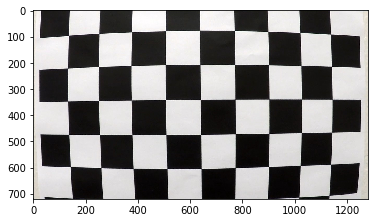

In [138]:
chessboard = mpimg.imread(cal_imgs[12])
plt.imshow(chessboard)

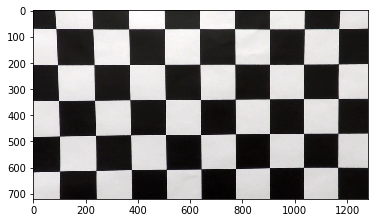

In [139]:
plt.imshow(cv2.undistort(chessboard, mtx, dist))

### test a road image

In [140]:
test_image_dist = mpimg.imread(test_images[1])

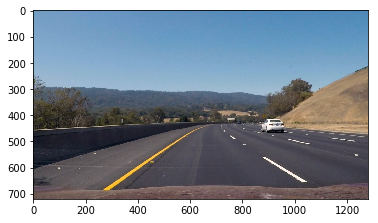

In [141]:
plt.imshow(test_image_dist)

In [142]:
test_image = cv2.undistort(test_image_dist, mtx, dist)

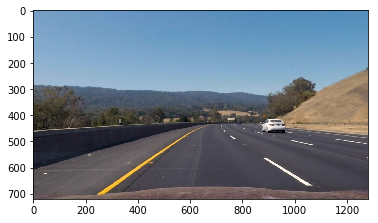

In [143]:
plt.imshow(test_image)

# Thresholding

## Gradient

### Sobel for x direction

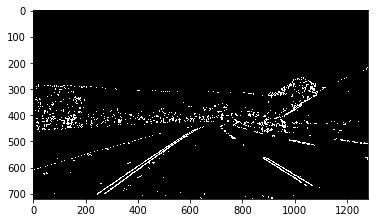

In [144]:
x_binary = lib.abs_sobel_thresh(test_image, orient='x', sobel_kernel=5, thresh=(20, 150))
plt.imshow(x_binary, cmap='gray')

## HLS

### S channel

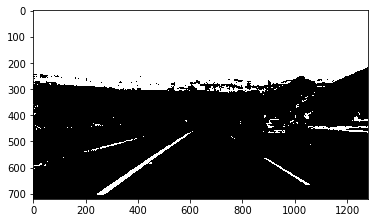

In [145]:
s_binary = lib.s_channel_threshold(test_image, thresh=(90, 255))[1]
plt.imshow(s_binary, cmap='gray')

### H channel

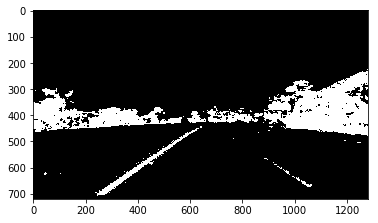

In [146]:
h_binary = lib.h_channel_threshold(test_image, thresh=(15, 50))[1]
plt.imshow(h_binary, cmap='gray')

## Combined HLS and Sobel thresholds

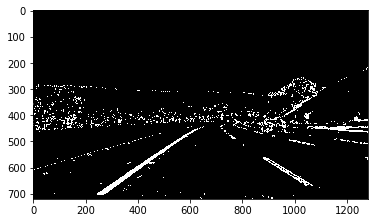

In [147]:
combined_binary = np.zeros_like(s_binary)
combined_binary[((h_binary == 1) & (s_binary == 1)) | (x_binary == 1)] = 1
plt.imshow(combined_binary, cmap='gray')

# Perspective Transform

In [148]:
warped, M, M_inv = lib.warp(combined_binary)

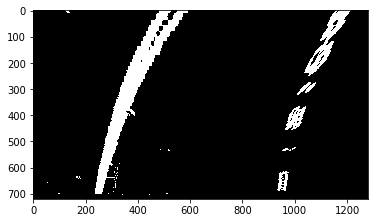

In [149]:
plt.imshow(warped, cmap ='gray')

# Fit lines

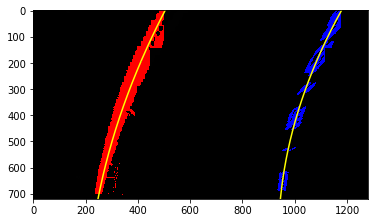

In [150]:
out_img, left_fitx, right_fitx = lib.fit_polynomial(warped, 5)
plt.imshow(out_img)

# Project back

In [151]:
res = lib.unwarp(warped, test_image_dist, M_inv, left_fitx, right_fitx)

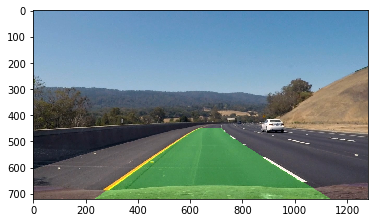

In [152]:
plt.imshow(res)